<a href="https://colab.research.google.com/github/RLAshish/OIPSIB_DataScience_Task-4/blob/main/Task_4_E_mail_spam_detection_in_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

# Sklearn for ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

# NLTK for NLP
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Loading the Dataset and Exploring it

In [ ]:
# Load dataset
df = pd.read_csv('spam.csv', encoding='latin-1')

# Initial look
print("First 5 rows:\n", df.head())

# Shape & column names
print("\nShape:", df.shape)
print("\nColumn names:", df.columns.tolist())

# Drop irrelevant columns
df = df[['v1', 'v2']]
df.columns = ['label', 'message']


First 5 rows:
      v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  

Shape: (5572, 5)

Column names: ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']


Cleaning & Label Encoding



In [ ]:
# Map labels to binary values
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Check class distribution
print("\nLabel distribution:\n", df['label'].value_counts())

# Null check
print("\nMissing values:\n", df.isnull().sum())



Label distribution:
 label
0    4825
1     747
Name: count, dtype: int64

Missing values:
 label      0
message    0
dtype: int64


Feature Engineering of Message Length & Punctuation Count columns




Statistical Summary:
              label   msg_length  punct_count
count  5572.000000  5572.000000  5572.000000
mean      0.134063    80.118808     4.207825
std       0.340751    59.690841     4.650857
min       0.000000     2.000000     0.000000
25%       0.000000    36.000000     2.000000
50%       0.000000    61.000000     3.000000
75%       0.000000   121.000000     6.000000
max       1.000000   910.000000   133.000000


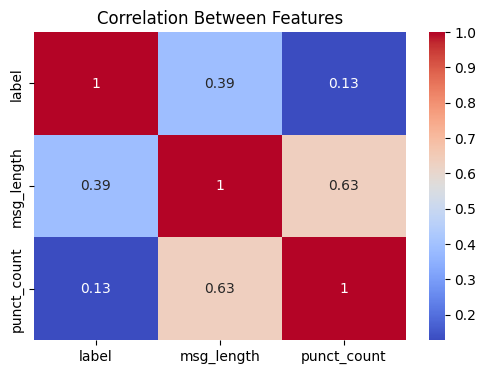

In [ ]:
# Add message length and punctuation count
df['msg_length'] = df['message'].apply(len)
df['punct_count'] = df['message'].apply(lambda x: sum([1 for char in x if char in string.punctuation]))

# Summary statistics
print("\nStatistical Summary:\n", df.describe())

# Correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df[['label', 'msg_length', 'punct_count']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Features")
plt.show()


Message Length Distribution


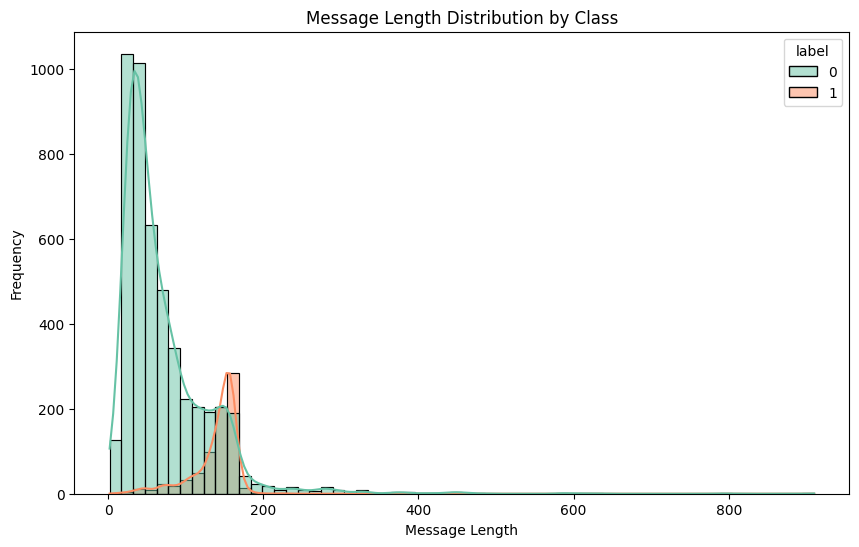

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='msg_length', hue='label', bins=60, kde=True, palette='Set2')
plt.title("Message Length Distribution by Class")
plt.xlabel("Message Length")
plt.ylabel("Frequency")
plt.show()


Class Distribution

<ipython-input-6-975489186>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='husl')


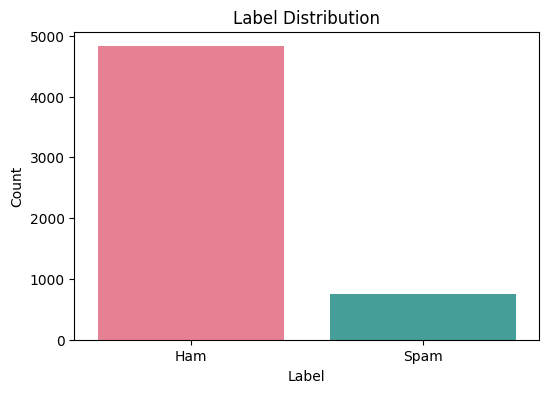

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label', palette='husl')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


Punctuation Count Distribution


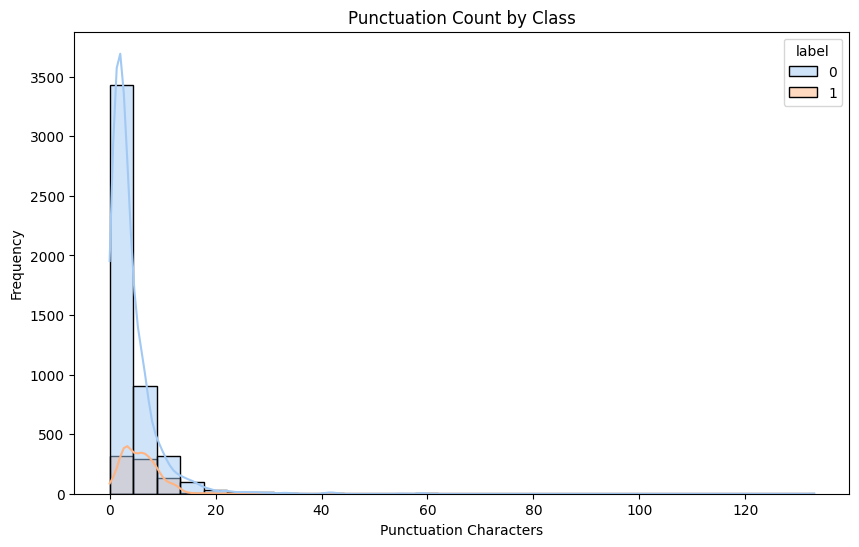

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='punct_count', hue='label', bins=30, kde=True, palette='pastel')
plt.title("Punctuation Count by Class")
plt.xlabel("Punctuation Characters")
plt.ylabel("Frequency")
plt.show()


Text Cleaning Function

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    return text

df['cleaned_message'] = df['message'].apply(clean_text)


Viewing Cleaned Text Examples

In [ ]:
# View original vs cleaned text
print(df[['message', 'cleaned_message']].head())


                                             message  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                     cleaned_message  
0  go until jurong point crazy available only in ...  
1                            ok lar joking wif u oni  
2  free entry in  a wkly comp to win fa cup final...  
3        u dun say so early hor u c already then say  
4  nah i dont think he goes to usf he lives aroun...  


Train-Test Split

In [ ]:
X = df['cleaned_message']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training samples:", len(X_train))
print("Test samples:", len(X_test))


Training samples: 4457
Test samples: 1115


ML Pipeline

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('model', MultinomialNB())
])


Training the Model

In [ ]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('bow', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()), ('model', MultinomialNB())])

Make Predictions

In [ ]:
y_pred = pipeline.predict(X_test)

# Show prediction samples
print("\nSample predictions:")
for i in range(5):
    print(f"\nMessage: {X_test.iloc[i]}\nActual: {y_test.iloc[i]} | Predicted: {y_pred[i]}")



Sample predictions:

Message: funny fact nobody teaches volcanoes  erupt tsunamis  arise hurricanes  sway aroundn no  teaches hw  choose a wife natural disasters just happens
Actual: 0 | Predicted: 0

Message: i sent my scores to sophas and i had to do secondary application for a few schools i think if you are thinking of applying do a research on cost also contact joke ogunrinde her school is one me the less expensive ones
Actual: 0 | Predicted: 0

Message: we know someone who you know that fancies you call  to find out who pobox   
Actual: 1 | Predicted: 0

Message: only if you promise your getting out as soon as you can and youll text me in the morning to let me know you made it in ok
Actual: 0 | Predicted: 0

Message: congratulations ur awarded either å£ of cd gift vouchers  free entry  our å£ weekly draw txt music to  tncs 
Actual: 1 | Predicted: 1


Evaluation of Performance



In [ ]:
# Accuracy
print("\nAccuracy:", accuracy_score(y_test, y_pred))

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.9659192825112107

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.75      0.85       150

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115



Confusion Matrix

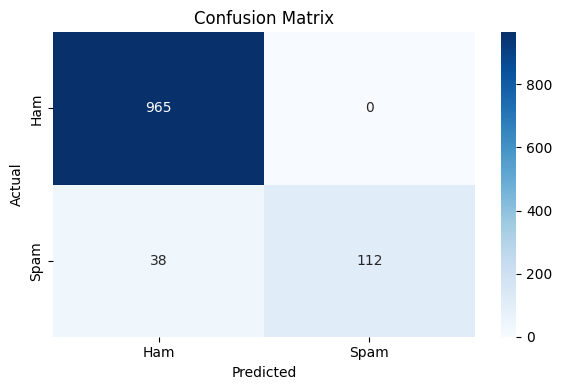

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [ ]:
# Get steps from pipeline
vect = pipeline.named_steps['bow']
model = pipeline.named_steps['model']
feature_names = vect.get_feature_names_out()

# Get log probabilities for spam class (index 1)
spam_class_index = 1
log_probs = model.feature_log_prob_[spam_class_index]

# Get top 10 indicative words for spam
top_spam_indices = log_probs.argsort()[-10:][::-1]  # Top 10 in descending order
top_spam_words = [feature_names[i] for i in top_spam_indices]

print("\nTop Spam Words:\n", top_spam_words)



Top Spam Words:
 ['free', 'txt', 'claim', 'mobile', 'prize', 'stop', 'ur', 'text', 'won', 'reply']
